In [1]:
import linsolve
import tf_linsolve
import scipy
import tensorflow as tf
import numpy as np
import pylab as plt
from copy import deepcopy
%load_ext line_profiler
%load_ext snakeviz

from hera_cal import utils
from hera_cal.redcal import RedundantCalibrator, get_reds, make_sol_finite, calibrate_in_place, redundantly_calibrate
from hera_sim.antpos import hex_array
from hera_sim.vis import sim_red_data

from hera_cal.redcal import redcal_iteration

from tqdm import tqdm
import itertools

In [3]:
!pip install git+https://github.com/tyler-a-cox/linsolve

  Cloning https://github.com/tyler-a-cox/linsolve to /private/var/folders/kv/bmmfw089255d48342x5bshcw0000gn/T/pip-req-build-hlwngm15
  Running command git clone -q https://github.com/tyler-a-cox/linsolve /private/var/folders/kv/bmmfw089255d48342x5bshcw0000gn/T/pip-req-build-hlwngm15
  Using cached numpy-1.19.5-cp38-cp38-macosx_10_9_x86_64.whl (15.6 MB)
  Created wheel for tf-linsolve: filename=tf_linsolve-1.1.0-py3-none-any.whl size=56125 sha256=504732ffac6ffcc85d7633ea41e3f04f7a17cffdd436bc05de5b703dbb1a6c9a
  Stored in directory: /private/var/folders/kv/bmmfw089255d48342x5bshcw0000gn/T/pip-ephem-wheel-cache-04qsbr2r/wheels/aa/0c/45/09b382ae34302a3a6f4bf40d93ebb0dc1d0aceef8370896a5f
Successfully built tf-linsolve
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4


## Realistic Example

In [45]:
antpos = hex_array(4, split_core=False, outriggers=False)
reds = get_reds(antpos)
freqs = np.linspace(100e6, 200e6, 100)
true_gains, true_vis, data = sim_red_data(reds, shape=(1, 100))
data = {
    k: v.astype(np.complex64) + np.random.normal(0, 0.1, size=(1, 100)).astype(np.float32) + 1j * np.random.normal(0, 0.1, size=(1, 100)).astype(np.float32)
    for k, v in data.items()
}

/usr/local/anaconda3/lib/python3.8/site-packages/hera_sim/noise.py:204: UserWarning: white_noise is being deprecated. Use utils.gen_white_noise instead.
  warnings.warn("white_noise is being deprecated. Use utils.gen_white_noise instead.")


In [46]:
red_grp = [list(itertools.combinations(red, 2)) for red in reds]
red_grp = sum(red_grp, [])
max_grps = 25000
niter = len(red_grp) // max_grps + 1

In [47]:
Ngrps = 25000
Nfreqs = 200
Ntimes = 20
Nbits = 64

In [48]:
times_by_bl = {k[:2]: np.array([[2458092]]) for k in data.keys()}

In [49]:
#np.savez('hera_sim.npz', data=data, freqs=freqs, antpos=antpos)

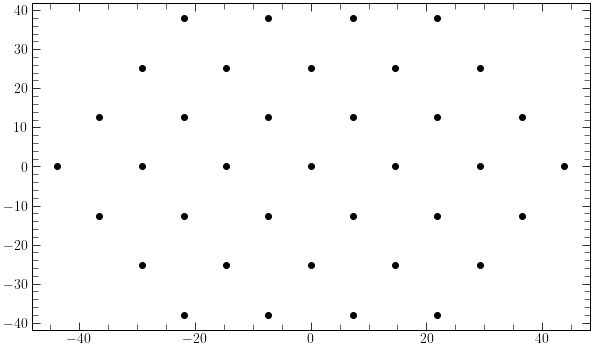

In [50]:
plt.figure(figsize=(10, 6))
for k, v in antpos.items():
    plt.scatter(v[0], v[1], color='k')
    
plt.show()

In [51]:
info_new = tf_linsolve.redcal.RedundantCalibrator(reds)
info = RedundantCalibrator(reds)
wgts = {k: np.ones((1, 100)) for k in data.keys()}

In [52]:
%%time
meta, sol0_baseline = info_new.firstcal(data, freqs, max_grps=100, min_vis_per_ant=None)
meta, log_sol_baseline = info_new.logcal(data, sol0=sol0_baseline)
meta, sol_baseline = info_new.omnical(data, log_sol_baseline, wgts=wgts, maxiter=500)

CPU times: user 7.32 s, sys: 333 ms, total: 7.65 s
Wall time: 5.46 s


In [53]:
%%time
meta, sol0 = info.firstcal(data, freqs)
meta, log_sol = info.logcal(data, sol0=sol0)
meta, sol = info.omnical(data, log_sol, wgts=wgts, maxiter=500)

CPU times: user 9.67 s, sys: 318 ms, total: 9.99 s
Wall time: 7.79 s


In [54]:
%%time
meta, solb = info.firstcal(data, freqs)
meta, log_solb = info.logcal(data, sol0=solb)
meta, solab = info.omnical(data, log_solb, wgts=wgts, maxiter=500)

CPU times: user 9.73 s, sys: 328 ms, total: 10.1 s
Wall time: 7.86 s


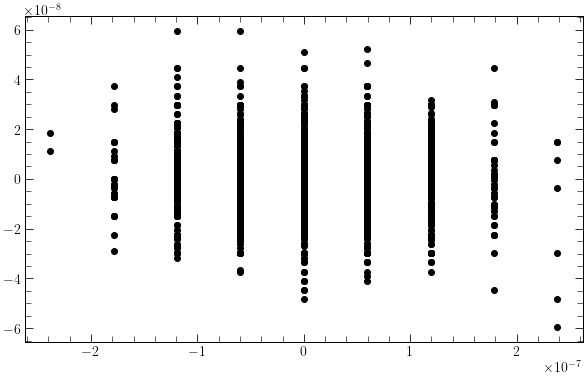

In [55]:
plt.figure(figsize=(10, 6))
for k in sol0_baseline.keys():
    if len(k) < 3:
        plt.scatter(
            sol[k][0].real - solab[k][0].real,
            sol[k][0].imag - solab[k][0].imag,
            color='k'
        )

#plt.xlim([-2e-7, 2e-7])
#plt.ylim([-2e-7, 2e-7])
plt.show()

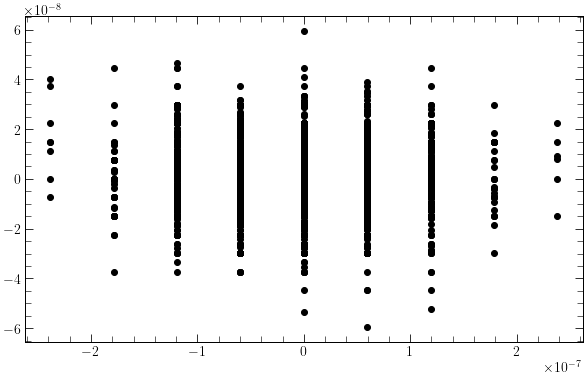

In [56]:
plt.figure(figsize=(10, 6))
for k in sol0_new.keys():
    if len(k) < 3:
        plt.scatter(
            sol[k][0].real - sol_baseline[k][0].real,
            sol[k][0].imag - sol_baseline[k][0].imag,
            color='k'
        )

#plt.xlim([-2e-7, 2e-7])
#plt.ylim([-2e-7, 2e-7])
plt.show()

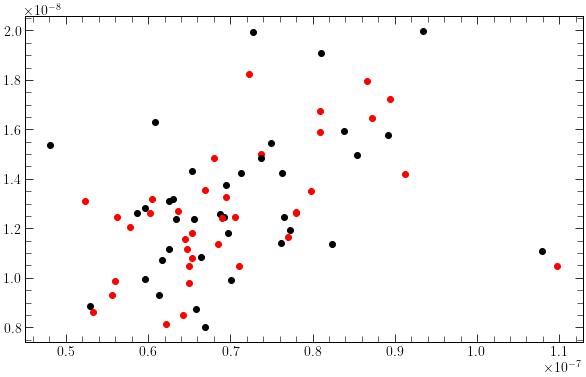

In [58]:
plt.figure(figsize=(10, 6))
for k in sol.keys():
    if len(k) < 3:
        plt.scatter(
            np.sqrt(np.mean(np.square(sol[k][0].real - sol_baseline[k][0].real))),
            np.sqrt(np.mean(np.square(sol[k][0].imag - sol_baseline[k][0].imag))),
            color='r'
        )
        
        plt.scatter(
            np.sqrt(np.mean(np.square(sol[k][0].real - solab[k][0].real))),
            np.sqrt(np.mean(np.square(sol[k][0].imag - solab[k][0].imag))),
            color='k'
        )

plt.show()

In [59]:
import tqdm
import time

In [60]:
sols = []
times = []
for i in tqdm.tqdm(range(20, 500, 20)):
    start = time.time()
    meta, sol0_new = info_new.firstcal(data, freqs, max_grps=100, min_vis_per_ant=i)
    meta, log_sol_new = info_new.logcal(data, sol0=sol0_new)
    meta, sol_new = info_new.omnical(data, log_sol_new, wgts=wgts, maxiter=500)
    sols.append(sol_new)
    times.append(time.time() - start)

100%|██████████| 24/24 [01:50<00:00,  4.59s/it]


In [61]:
reals = []
imags = []
for si, s in enumerate(sols):
    reals.append([])
    imags.append([])
    for k in sol0_new.keys():
        if len(k) < 3:
            real = sol[k][0].real - s[k][0].real
            imag = sol[k][0].imag - s[k][0].imag
            
            reals[si].append(np.mean(np.square(real)))
            imags[si].append(np.mean(np.square(imag)))
            

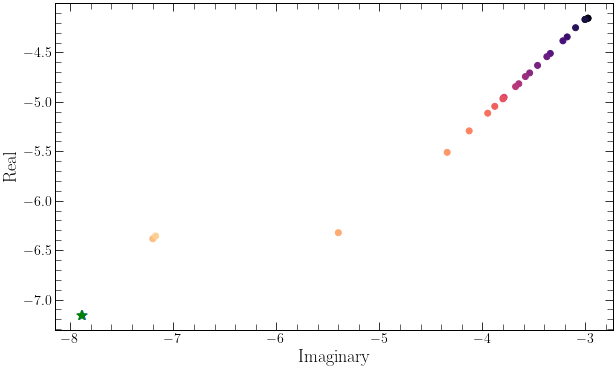

In [62]:
plt.figure(figsize=(10, 6))
cm = plt.cm.magma(np.linspace(0, 0.9, 24))
plt.scatter(np.log10(np.sqrt(np.mean(imags, axis=1))), np.log10(np.sqrt(np.mean(reals, axis=1))), color=cm)
plt.xlabel('Imaginary')
plt.ylabel('Real')


rs = []
irs = []
for k in sol.keys():
    if len(k) < 3:
        rs.append(np.sqrt(np.mean(np.square(sol[k][0].real - solab[k][0].real))))
        irs.append(np.sqrt(np.mean(np.square(sol[k][0].imag - solab[k][0].imag))))
        
plt.scatter(np.log10(np.mean(irs)), np.log10(np.mean(rs)), marker='*', s=100)


rs = []
irs = []
for k in sol.keys():
    if len(k) < 3:
        rs.append(np.sqrt(np.mean(np.square(sol[k][0].real - sol_baseline[k][0].real))))
        irs.append(np.sqrt(np.mean(np.square(sol[k][0].imag - sol_baseline[k][0].imag))))
        
plt.scatter(np.log10(np.mean(irs)), np.log10(np.mean(rs)), marker='*', s=100, color='green')

#plt.xlim([-8, -2])
#plt.ylim([-8, -2])
plt.show()

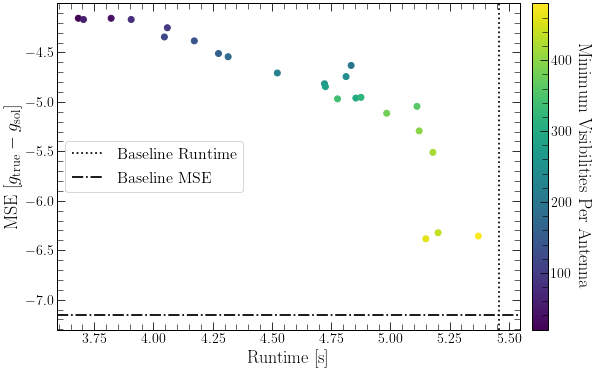

In [114]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(times, np.log10(np.sqrt(np.mean(reals, axis=1))), c=range(20, 500, 20), cmap='viridis')
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('Minimum Visibilities Per Antenna', rotation=270, labelpad=20)
plt.axvline(5.46, color='k', ls=':', label='Baseline Runtime')
plt.axhline(np.log10(np.mean(rs)), color='k', ls='-.', label='Baseline MSE')
plt.legend(fontsize=16)
plt.xlabel(r'Runtime $[\rm s]$')
plt.ylabel(rd'MSE $[g_{\rm true} - g_{\rm sol}]$')
plt.show()

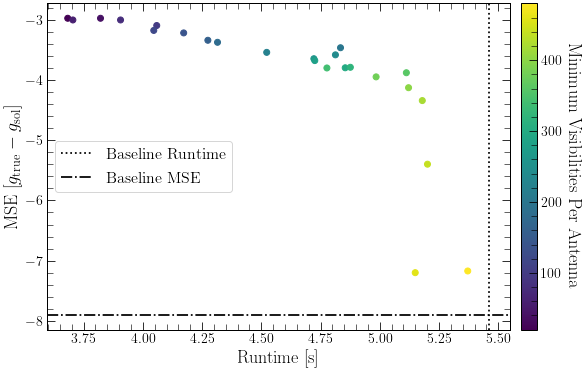

In [115]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(times, np.log10(np.sqrt(np.mean(imags, axis=1))), c=range(20, 500, 20), cmap='viridis')
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('Minimum Visibilities Per Antenna', rotation=270, labelpad=20)
plt.axvline(5.46, color='k', ls=':', label='Baseline Runtime')
plt.axhline(np.log10(np.mean(irs)), color='k', ls='-.', label='Baseline MSE')
plt.legend(fontsize=16)
plt.xlabel(r'Runtime $[\rm s]$')
plt.ylabel(r'MSE $[g_{\rm true} - g_{\rm sol}]$')
plt.show()

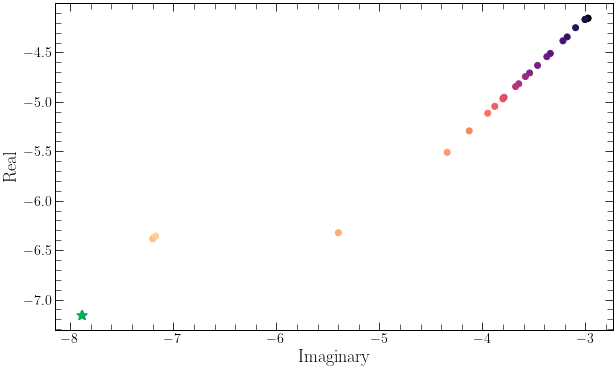

In [107]:
plt.figure(figsize=(10, 6))
cm = plt.cm.magma(np.linspace(0, 0.9, 24))
plt.scatter(np.log10(np.sqrt(np.mean(imags, axis=1))), np.log10(np.sqrt(np.mean(reals, axis=1))), color=cm)
plt.xlabel('Imaginary')
plt.ylabel('Real')


rs = []
irs = []
for k in sol.keys():
    if len(k) < 3:
        rs.append(np.sqrt(np.mean(np.square(sol[k][0].real - solab[k][0].real))))
        irs.append(np.sqrt(np.mean(np.square(sol[k][0].imag - solab[k][0].imag))))
plt.scatter(np.log10(np.mean(irs)), np.log10(np.mean(rs)), marker='*', s=100)

rs = []
irs = []
for k in sol.keys():
    if len(k) < 3:
        rs.append(np.sqrt(np.mean(np.square(sol[k][0].real - sol_baseline[k][0].real))))
        irs.append(np.sqrt(np.mean(np.square(sol[k][0].imag - sol_baseline[k][0].imag))))
plt.scatter(np.log10(np.mean(irs)), np.log10(np.mean(rs)), marker='*', s=100)

plt.show()